**Mount the Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/My Drive/torchkit')

**Import all Libraries**

In [4]:
from dataloaders import Data_To_Dataloader
from albtransforms import SingleChannel_ImageTransforms, AlbumentationTransforms
from loss_funcs import *
import lr_finder
from utils import zip_data
from s15_customdataset import DepthMapDataset
from UNet import UNet
from setup import hardware_specs

**Hardware Properties**

In [9]:
hardware_specs()

"PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)"

**Initialize Tensorboard Object**

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

writer = SummaryWriter()

**Unzip the File**

In [ ]:
path = '/content/drive/My Drive/ZipFiles/data_TenK101.zip'
save = '/content/drive/My Drive/Videos'
zip_data(zipfile,path, save)

Outside loop
Extracting ZIP
Zipfile extracted to /content/drive/My Drive/Videos


**Set the path for all 4 type of Images**

In [5]:
import os
zip_path = "/content/drive/My Drive/ZipExtract/data_TenK101"
subd = os.listdir(zip_path) #Returns sub-directories

bg_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG'

bgfg_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG' 

bgfg_mask_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks'

depthmap_path = '/content/drive/My Drive/ZipExtract/data_TenK101/DepthMaps'


**Some basic checks**

In [ ]:
sorted(os.listdir(bgfg_mask_path))[:-10]

In [ ]:
from PIL import Image
import cv2
img = cv2.imread('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_001.jpeg')
img.shape

(224, 224, 3)

In [ ]:
foldersize=[len(os.listdir(path)) for path in [bg_path, bgfg_path, bgfg_mask_path, depthmap_path]]
foldersize

[100, 10000, 10000, 10000]

In [ ]:
mask = sorted([ file for file in os.listdir(bgfg_mask_path)])
mask[:4]



**Dataset Creation**

In [6]:
# NOTE: Have done a lot of commenting below, because it's tricky.

# Now the first task is to clip input and output
# This is done since BG has only 100 images while BG_FG has around 400K, but for this I'm using 10K
# Now to do this I've used this snippet below, which will clip in the inputs with it's corresponding ground truth

masks = [mask for mask in os.listdir(bgfg_mask_path)] # Mask Files

bg_idx = [int(m.split('_')[1]) for m in masks] # Background file index


bgfiles = [os.path.join(bg_path, bg) for bg in os.listdir(bg_path)] # all 100 BG Files
bg_files = sorted([os.path.join(bgfg_mask_path, bgfiles[idx-1]) for idx in bg_idx ]) # BG Files of Proper index


**Zipping Data Elements**

In [7]:
# I have zipped both bg and bg_fg as image segmentation input.
bg_files = sorted([os.path.join(bgfg_mask_path, bgfiles[idx-1]) for idx in bg_idx ]) # BG Files
bgfg_mask_files = sorted([os.path.join(bgfg_mask_path, mask) for mask in os.listdir(bgfg_mask_path)]) #BGFG MASK Files
bgfg_files = sorted([os.path.join(bgfg_path, bgfg) for bgfg in os.listdir(bgfg_path)]) # BGFG files
dpmap_files = sorted([os.path.join(depthmap_path, map) for map in os.listdir(depthmap_path)]) #DEPTH MAP

s15_data = list(zip(bg_files, bgfg_files, bgfg_mask_files, dpmap_files)) # for bg add rev_bg_files directly and for depth estimation you can add depth maps


**Image Transformations**

In [8]:
import albumentations as A
import albumentations.pytorch as AP

# BG Images
bg_mean = (0.5411, 0.54, 0.54)
bg_stdev = (0.2320, 0.23, 0.23)

# FG_BG Images
fgbg_mean = (0.513, 0.536, 0.5546)
fgbg_stdev = (0.2355, 0.2317, 0.2326)

# FG Mask Images   # SINGLE CHANNEL
mask_mean = (0.051)
mask_stdev = (0.226)#, 0.4025, 0.4025)

# Depth Maps
dpmap_mean = (0.3045)
dpmap_stdev = (0.1130)

# Used same type of transformations for both Train & Test Data

bg_transform = AlbumentationTransforms([A.Resize(192,192,p=1),
                                                A.Normalize(mean=bg_mean,
                                                std=bg_stdev)])

bgfg_transform = AlbumentationTransforms([A.Resize(192,192,p=1),
                                                # A.HueSaturationValue(p=1),
                                                A.Normalize(mean=fgbg_mean,
                                              std=fgbg_stdev)])

bgfg_mask_transform = SingleChannel_ImageTransforms([A.Resize(192,192,p=1),
                                                    A.Normalize(mean=mask_mean,
                                                    std=mask_stdev)])

dpmap_transform = SingleChannel_ImageTransforms([A.Resize(192,192,p=1),
                                                 A.Normalize(mean=dpmap_mean,
                                                std=dpmap_stdev)])

transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f7cc1bd5ef0>, <albumentations.augmentations.transforms.Normalize object at 0x7f7cc1bd5f28>, <albumentations.pytorch.transforms.ToTensor object at 0x7f7cc1bd5f98>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f7cc1bd5eb8>, <albumentations.augmentations.transforms.Normalize object at 0x7f7cc1bab080>, <albumentations.pytorch.transforms.ToTensor object at 0x7f7cc1bab0f0>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f7cc1bab048>, <albumentations.augmentations.transforms.Normalize object at 0x7f7cc1bab198>, <albumentations.pytorch.transforms.ToTensor object at 0x7f7cc1bab208>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f7cc1bab160>, <albumentations.augmentations.transforms.Normalize object at 0x7f7cc1bab2b0>, <albumentations.pytorch.transforms.ToTensor object at 0x7f7cc1bab320>]


In [9]:
_s15 = s15_data[:5001] # using a subset of only 5000 images out of s15_data

In [10]:
train = DepthMapDataset(_s15[:3500], bg_transform,  bgfg_transform, bgfg_mask_transform, dpmap_transform) #bg_transform,, dpmap_transform)
test = DepthMapDataset(_s15[3501:], bg_transform, bgfg_transform, bgfg_mask_transform, dpmap_transform)

**TRAINLOADER & TESTLOADER**

In [11]:
trainLoader, testLoader = Data_To_Dataloader(train,test,batch_size=64)

**Writing to Tensorboard**

In [ ]:
import matplotlib.pyplot as plt
dataiter = iter(trainLoader)
bg, bgfg, mask, dpmap = next(dataiter)['bg'], next(dataiter)['bgfg'], next(dataiter)['mask'], next(dataiter)['dpmap']

bgfg_grid = torchvision.utils.make_grid(bgfg)

# matplotlib_imshow(bgfg_images)
writer.add_image('BG_FG Images', bgfg_grid)

In [ ]:
# %tensorboard -- logdir=/content/runs/Aug05_10-08-37_c31f995905fa
%tensorboard --logdir logs/tensorboard

In [12]:
from torchsummary import summary
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
unet_model = UNet(6,1).to(device)

summary(unet_model, input_size=(6, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 192, 192]             880
       BatchNorm2d-2         [-1, 16, 192, 192]              32
           Dropout-3         [-1, 16, 192, 192]               0
              ReLU-4         [-1, 16, 192, 192]               0
            Conv2d-5         [-1, 16, 192, 192]           2,320
       BatchNorm2d-6         [-1, 16, 192, 192]              32
           Dropout-7         [-1, 16, 192, 192]               0
              ReLU-8         [-1, 16, 192, 192]               0
        DoubleConv-9         [-1, 16, 192, 192]               0
        MaxPool2d-10           [-1, 16, 96, 96]               0
           Conv2d-11           [-1, 32, 96, 96]           4,640
      BatchNorm2d-12           [-1, 32, 96, 96]              64
          Dropout-13           [-1, 32, 96, 96]               0
             ReLU-14           [-1, 32,

**LOSS FUNCTIONS & CO-EFFICIENT**

In [13]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

unet_model = UNet(6,1).to(device)  # MODEL

# CRITERION PART
depth_c = IoULoss() 
mask_c = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(unet_model.parameters(), lr = 0.01)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=0.001)


# Model Config Class
class ModelConfig:
  def __init__(self, **kwargs):
    for k, v in kwargs.items():
      setattr(self, k, v)


# Model Configs
model_config = ModelConfig(
    cuda = True if torch.cuda.is_available() else False,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    seed = 9091,
    model = unet_model, 
    trainloader = trainLoader,
    testloader = testLoader, 
    lr = 0.01,
    mask_criterion = mask_c,
    depth_criterion = depth_c,
    optimizer = torch.optim.Adam(unet_model.parameters(),lr=0.01),
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True),
    epochs = 10,
    save_model = False,
    batch_size = 64,)


In [21]:

import time
from tqdm import notebook
class Trainer:
  def __init__(self, config):
    self.model = config.model
    self.device = config.device
    self.trainloader = config.trainloader
    self.testloader = config.testloader
    self.epochs = config.epochs
    self.optimizer = config.optimizer
    self.scheduler = config.scheduler
    self.mask_criterion = config.mask_criterion
    self.depth_criterion = config.depth_criterion
    self.valid_loss_min = np.inf

    # initialize training variables
    self.train_losses = []
    self.test_losses = []
    self.learning_rate = []

    # loss coeffs 
    ## TRAIN
    self.dice_scores = []
    self.iou_scores = [] 
    self.d_ssim_index = []
  
    ## TEST 
    self.test_dice_scores = []
    self.test_iou_scores = []
    self.test_d_ssim_index = []
 

    # Sample Container
    self._trainsamples = []
    self._testsamples = []


    # train_loss, valid_loss, dice_score, iou_score, mask_ssim_index
    self.train_loss = 0.0
    self.valid_loss = 0.0

    self.iou_score = 0.0
    self.depth_ssim_index = 0.0
    

    # # TensorboardColab
    # self.tb = TensorboardColab()
    # self.train_iter = 0
    # self.test_iter = 0

    # other variables
    self.epoch = 0


  def train(self):
    self.epoch += 1
    self.model.train()  
    self.epoch_start = time.time()    
    pbar = notebook.tqdm(enumerate(self.trainloader))

    for batch_idx, data in enumerate(pbar):     

        # assigning bgfg and mask with a bgfg and mask image from trainloader
        bg, bgfg, mask, dpmap = data[1]['bg'].to(self.device), data[1]['bgfg'].to(self.device), data[1]['mask'].to(self.device), data[1]['dpmap'].to(self.device)
        
        input_image = data[1]['input'].to(self.device)
      
        # clear the gradients of all optimized variables
        self.optimizer.zero_grad()

        # Run the model on this input batch
        pred_mask, pred_dpmap = self.model(input_image) # 96x96x2
        
        # calculate loss using criterion
        maskloss = self.mask_criterion(pred_mask, mask) # Output, Target
        dpmaploss = self.depth_criterion(pred_dpmap, dpmap)

        depth_ssim_index = ssim(pred_dpmap, dpmap) # ssim loss function
        depth_ssim = torch.clamp((1 - ssim(pred_dpmap, dpmap)) * 0.5, 0, 1)

        
        loss =  (depth_ssim *0.9 + dpmaploss *0.1 + maskloss)

        # for backpropagation
        loss.backward()

        # parameter update
        self.optimizer.step()

        # For checking input images
        # For checking input images
        if self.epoch == 5: #
          self._trainsamples.append({'pred_dpmap':pred_dpmap, 'pred_mask': pred_mask,'dpmap': dpmap, 'mask': mask, 'bgfg': bgfg, 'bg': bg})

        # calculate average training loss
        train_data_size = len(self.trainloader)*self.trainloader.batch_size
        self.train_loss += loss.item() #*trainLoader.batch_size

        self.depth_ssim_index += depth_ssim.item()*self.trainloader.batch_size

        self.iou_score += (1-maskloss.item())*self.trainloader.batch_size
        # rmse_score += (rmse_v.item())*trainLoader.batch_size


        # Update PBAR-TQDM
        pbar.set_description(f'TrainLoss={loss.item():0.3f}; IoU={1-dpmaploss.item():0.3f}')
        
        
    # Calculate Avg Model Params
    train_loss = self.train_loss/len(self.trainloader)
    depth_ssim_index = self.depth_ssim_index/train_data_size
    # rmse = rmse_score/train_data_size
    iou = self.iou_score/train_data_size
    
    # Append the same
    self.train_losses.append(train_loss)
    # self.dice_scores.append(dice_score)
    self.d_ssim_index.append(depth_ssim_index)
    self.iou_scores.append(iou)
    
    
    # # writing model attr to tensorboard
    # self.tb.save_value('IoU Score', 'iou score', self.train_iter, iou_score)
    # self.tb.save_value('Train Loss', 'train loss', self.train_iter, train_loss) 
    

  def test(self):
    self.model.eval()
    pbar = notebook.tqdm(enumerate(self.testloader))
    with torch.no_grad(): 
      for batch_idx, data in enumerate(pbar):
        bg, bgfg, mask, dpmap = data[1]['bg'].to(self.device), data[1]['bgfg'].to(self.device), data[1]['mask'].to(self.device), data[1]['dpmap'].to(self.device)

        # concatenate two input images
        input_image = data[1]['input'].to(device)

        # Model Predictions
        pred_mask, pred_dpmap = self.model(input_image) 
        
        # calculate loss using criterion
        maskloss = self.mask_criterion(pred_mask, mask) # Output, Target
        dpmaploss = self.depth_criterion(pred_dpmap, dpmap)

        depth_ssim_index = ssim(pred_dpmap, dpmap)
        depth_ssim = torch.clamp((1 - ssim(pred_dpmap, dpmap)) * 0.5, 0, 1)

        
        loss =  (depth_ssim *0.8 + dpmaploss *0.2 + maskloss)


        # calculate average test loss
        test_data_size = len(self.testloader)*self.testloader.batch_size
        self.valid_loss += loss.item()
        self.depth_ssim_index += depth_ssim_index.item()*self.testloader.batch_size
        # self.dice_score += (1-maskloss.item())*self.testloader.batch_size
        self.iou_score += (1-maskloss.item())*self.testloader.batch_size

        # Update PBAR-TQDM
        pbar.set_description(f'ValidationLoss={loss.item():0.3f}; IoU={1-maskloss.item():0.3f}')


        # For checking prediction results
        if self.epoch == 5: #
          self._testsamples.append({'pred_dpmap':pred_dpmap, 'pred_mask': pred_mask,'dpmap': dpmap, 'mask': mask, 'bgfg': bgfg, 'bg': bg})

      #  current lr
      clr = [param_group['lr'] for param_group in self.optimizer.param_groups]
      print('Learning Rate:', clr)

      # update loss and loss-coefficients
      self.valid_loss = self.valid_loss/len(self.testloader)
      self.depth_ssim_index = self.depth_ssim_index/test_data_size
      # dice_coeff = self.dice_score/test_data_size
      self.iou_coeff = self.iou_score/test_data_size

      # append the same 
      self.test_losses.append(self.valid_loss_min)
      self.test_d_ssim_index.append(self.depth_ssim_index)
      # self.m_ssim_index.append(mask_ssim_index)
      # self.dice_scores.append(dice_coeff)
      self.test_iou_scores.append(self.iou_coeff)
      self.learning_rate.append(clr)


      # update learning rate
      self.scheduler.step(self.valid_loss)



  # print training/validation statistics
    print('IoU_Score={:.3f} '.format(self.iou_coeff))


    self.end_epoch_time = time.time()
    print(f'Epoch {self.epoch} took {self.end_epoch_time-self.epoch_start} seconds.')

    # save model if validation loss has decreased
    if self.valid_loss <= self.valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(self.valid_loss_min, self.valid_loss))
      torch.save(self.model.state_dict(), '/content/drive/My Drive/Saved S15 Models/image_segmentation.pt')
      self.valid_loss_min = self.valid_loss
      

def evaluate(configs):
  t1 = Trainer(configs)
  for epoch in range(t1.epoch+1):
    t1.train()
    t1.test()
    if t1.scheduler and isinstance(t1.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
      t1.scheduler.step(t1.test_losses[-1])

In [22]:
evaluate(model_config)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Learning Rate: [0.01]


NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


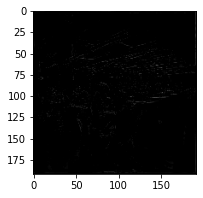

In [ ]:


import matplotlib.pyplot as plt
def image_show(tensors1):
    grid_tensor1 = torchvision.utils.make_grid(tensors1.detach().cpu())
    grid_image1 = grid_tensor1.permute(1,2,0)
    plt.figure(figsize=(3,3))
    plt.imshow(grid_image1)
    plt.show()
image_show( _testsamples[1]['pred_mask'][1])

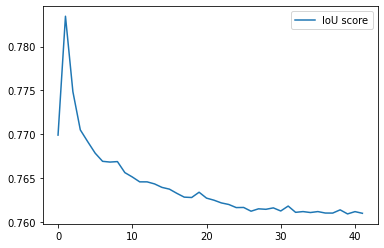

In [ ]:
import matplotlib.pyplot as plt # lr 0.0001
plt.plot(iou_coeffs, label='IoU score')
# plt.plot(valid_losses, label='ssim index')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


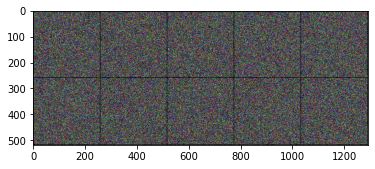

In [38]:
import torchvision
import matplotlib.pyplot as plt
# sample input (10 RGB images containing just Gaussian Noise)
batch_tensor = torch.randn(*(10, 3, 256, 256))   # (N, C, H, W)

# # make grid (2 rows and 5 columns) to display our 10 images
# grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))
# batch_tensor.size()